In [67]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from catboost import CatBoostRegressor, Pool
import shap
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from lightgbm import LGBMRegressor
from scipy.stats import skew

All the libraries that were used in the code have been imported here


In [69]:
df=pd.read_csv('Pearl Challenge data with dictionary.xlsx.csv')
df.head(5)

,FarmerID,State,REGION,SEX,CITY,Zipcode,DISTRICT,VILLAGE,MARITAL_STATUS,Location,...,Rabi Seasons Agro Ecological Sub Zone in 2020,Rabi Seasons Seasonal average groundwater thickness (cm) in 2020,Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2020,Night light index,Village score based on socio-economic parameters (Non normalised),Village score based on socio-economic parameters (0 to 100),"Village category based on socio-economic parameters (Good, Average, Poor)",Land Holding Index source (Total Agri Area/ no of people),Road density (Km/ SqKm),Target_Variable/Total Income
0,1002818465057450,MADHYA PRADESH,CENTRAL,M,BARELI,464668,RAISEN,Seoni,M,NaN,...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,97.24,19.50,0.95,22.38,33.53,Poor,0.77,0.00,1360000
1,1012300674433870,BIHAR,EAST,M,BANDRA,848125,MUZAFFARPUR,Namapur,M,NaN,...,DECCAN PLATEAU (TELANGANA) AND EASTERN GHATS ...,73.96,16.76,0.97,24.63,37.17,Poor,0.45,0.00,807200
2,1013472263587380,MADHYA PRADESH,CENTRAL,M,MALHARGARH,458556,MANDSAUR,Billaud,M,NaN,...,CENTRAL HIGHLANDS ( MALWA ) GUJARAT PLAIN AND...,90.05,22.44,0.95,19.49,28.85,Poor,0.66,0.00,500000
3,1019525480704050,MAHARASHTRA,WEST,M,RENAPUR,413527,LATUR,Renapur,M,NaN,...,DECCAN PLATU HOT SEMI-ARID ECO-REGION,94.64,21.48,0.98,31.84,48.85,Average,0.24,2.49,558000
4,1021915867444260,MADHYA PRADESH,CENTRAL,F,KHURAI,470117,SAGAR,Singhpur,M,NaN,...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,95.90,18.93,0.97,21.33,31.82,Poor,0.21,0.00,800000


This is the original dataset that was given to us

In [71]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47970 entries, 0 to 47969
Columns: 105 entries, FarmerID to Target_Variable/Total Income
dtypes: float64(63), int64(4), object(38)
memory usage: 38.4+ MB


In [72]:
numeric_cols = df.select_dtypes(include=['number']).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()
print(f"Number of numeric columns: {len(numeric_cols)}")
print("Numeric columns:")
for col in numeric_cols:
    print(col)
print("\n" + "-"*50 + "\n")
print(f"Number of categorical columns: {len(categorical_cols)}")
print("Categorical columns:")
for col in categorical_cols:
    print(col)

Number of numeric columns: 67
Numeric columns:
FarmerID
Zipcode
No_of_Active_Loan_In_Bureau
Avg_Disbursement_Amount_Bureau
Non_Agriculture_Income
Total_Land_For_Agriculture
K022-Proximity to nearest mandi (Km)
K022-Proximity to nearest railway (Km)
KO22-Village score based on socio-economic parameters (0 to 100)
K022-Seasonal Average Rainfall (mm)
R022-Seasonal Average Rainfall (mm)
K021-Seasonal Average Rainfall (mm)
R021-Seasonal Average Rainfall (mm)
R020-Seasonal Average Rainfall (mm)
Perc_of_house_with_6plus_room
Women_15_19_Mothers_or_Pregnant_at_time_of_survey
perc_of_pop_living_in_hh_electricity
perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms
mat_roof_Metal_GI_Asbestos_sheets
perc_of_Wall_material_with_Burnt_brick
Households_with_improved_Sanitation_Facility
perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k
K022-Total Geographical Area (in Hectares)-
K022-Net Agri area (in Ha)-
K022-Net Agri area (% of total geog area)-
Kharif Seasons  Irrigated area in 2

Data Cleaning and Preparation

In [74]:
pd.set_option('display.max_rows', None)
df.isnull().sum()

FarmerID                                                                              0
State                                                                                 0
REGION                                                                                0
SEX                                                                                   0
CITY                                                                                  0
Zipcode                                                                               0
DISTRICT                                                                              0
VILLAGE                                                                               0
MARITAL_STATUS                                                                        0
Location                                                                          17030
Address type                                                                      17030
Ownership                       

As we can see, there are some columns who have NaN values. We will start by dealing with "Perc_of_house_with_6plus_room, Women_15_19_Mothers_or_Pregnant_at_time_of_survey, perc_of_pop_living_in_hh_electricity, perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms, mat_roof_Metal_GI_Asbestos_sheets, perc_of_Wall_material_with_Burnt_brick, Households_with_improved_Sanitation_Facility, perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k, Total_Land_For_Agriculture" each have NaN values whose number is very low in comparision to 47970 rows, so we will remove them.

In [76]:
cols_to_check = ['Perc_of_house_with_6plus_room', 'Women_15_19_Mothers_or_Pregnant_at_time_of_survey', 'perc_of_pop_living_in_hh_electricity', 'perc_Households_with_Pucca_House_That_Has_More_Than_3_Rooms', 'mat_roof_Metal_GI_Asbestos_sheets', 'perc_of_Wall_material_with_Burnt_brick', 'Households_with_improved_Sanitation_Facility', 'perc_Households_do_not_have_KCC_With_The_Credit_Limit_Of_50k', 'Total_Land_For_Agriculture']
df.dropna(subset=cols_to_check, inplace=True)

We identified how many rows have a missing "Avg_Disbursement_Amount_Bureau" value despite having a non-zero "No_of_Active_Loan_In_Bureau", which highlights potential inconsistencies in the dataset.

In [78]:
mask = (df['No_of_Active_Loan_In_Bureau'] != 0) & (df['Avg_Disbursement_Amount_Bureau'].isna())

count = mask.sum()
print(f"Number of NaNs in 'Avg_Disbursement_Amount_Bureau' where 'No_of_Active_Loan_In_Bureau' is not zero: {count}")


Number of NaNs in 'Avg_Disbursement_Amount_Bureau' where 'No_of_Active_Loan_In_Bureau' is not zero: 0


This clearly shows that we can replace Nan values of 'Avg_Disbursement_Amount_Bureau' to 0 

In [80]:
df['Avg_Disbursement_Amount_Bureau'] = df['Avg_Disbursement_Amount_Bureau'].fillna(0)

In [81]:
pd.set_option('display.max_rows', None)
df.isnull().sum()

FarmerID                                                                              0
State                                                                                 0
REGION                                                                                0
SEX                                                                                   0
CITY                                                                                  0
Zipcode                                                                               0
DISTRICT                                                                              0
VILLAGE                                                                               0
MARITAL_STATUS                                                                        0
Location                                                                          16900
Address type                                                                      16900
Ownership                       

We are now examining whether there's a pattern in the missing values across the "Location", "Address type", and "Ownership" columns, since all three have the same number of NaNs — suggesting they might be missing together for the same rows.

In [83]:
cols = ['Location', 'Address type', 'Ownership']
nan_mask_equal = df[cols].isna().nunique(axis=1).eq(1).all()
if nan_mask_equal:
    print("NaN values occur in the same rows across all three columns.")
else:
    print("NaN values are not aligned across the three columns.")

NaN values occur in the same rows across all three columns.


This trend shows that NaN values are common across all three columns and have a large contribution in our dataset, so we are separating these columns, considering them as people with unregistered houses.

In [85]:
df['Address type'] = df['Address type'].fillna('Unregistered House')
df['Address type'].head(20)

0     Unregistered House
1     Unregistered House
2     Unregistered House
3     Unregistered House
4     Unregistered House
5      Permanent Address
6     Unregistered House
7      Permanent Address
8     Unregistered House
9      Permanent Address
10     Permanent Address
11     Permanent Address
12     Permanent Address
13    Unregistered House
14     Permanent Address
15     Permanent Address
16     Permanent Address
17     Permanent Address
18       Current Address
19    Unregistered House
Name: Address type, dtype: object

In [86]:
df_Unregistered_House = df[df['Address type'] == 'Unregistered House']

df_Registered_House = df[df['Address type'] != 'Unregistered House']

In [87]:
df_Unregistered_House.head()

,FarmerID,State,REGION,SEX,CITY,Zipcode,DISTRICT,VILLAGE,MARITAL_STATUS,Location,...,Rabi Seasons Agro Ecological Sub Zone in 2020,Rabi Seasons Seasonal average groundwater thickness (cm) in 2020,Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2020,Night light index,Village score based on socio-economic parameters (Non normalised),Village score based on socio-economic parameters (0 to 100),"Village category based on socio-economic parameters (Good, Average, Poor)",Land Holding Index source (Total Agri Area/ no of people),Road density (Km/ SqKm),Target_Variable/Total Income
0,1002818465057450,MADHYA PRADESH,CENTRAL,M,BARELI,464668,RAISEN,Seoni,M,NaN,...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,97.24,19.50,0.95,22.38,33.53,Poor,0.77,0.00,1360000
1,1012300674433870,BIHAR,EAST,M,BANDRA,848125,MUZAFFARPUR,Namapur,M,NaN,...,DECCAN PLATEAU (TELANGANA) AND EASTERN GHATS ...,73.96,16.76,0.97,24.63,37.17,Poor,0.45,0.00,807200
2,1013472263587380,MADHYA PRADESH,CENTRAL,M,MALHARGARH,458556,MANDSAUR,Billaud,M,NaN,...,CENTRAL HIGHLANDS ( MALWA ) GUJARAT PLAIN AND...,90.05,22.44,0.95,19.49,28.85,Poor,0.66,0.00,500000
3,1019525480704050,MAHARASHTRA,WEST,M,RENAPUR,413527,LATUR,Renapur,M,NaN,...,DECCAN PLATU HOT SEMI-ARID ECO-REGION,94.64,21.48,0.98,31.84,48.85,Average,0.24,2.49,558000
4,1021915867444260,MADHYA PRADESH,CENTRAL,F,KHURAI,470117,SAGAR,Singhpur,M,NaN,...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,95.90,18.93,0.97,21.33,31.82,Poor,0.21,0.00,800000


This shows us the People who have unregistered houses

In [89]:
df_Registered_House.head()

,FarmerID,State,REGION,SEX,CITY,Zipcode,DISTRICT,VILLAGE,MARITAL_STATUS,Location,...,Rabi Seasons Agro Ecological Sub Zone in 2020,Rabi Seasons Seasonal average groundwater thickness (cm) in 2020,Rabi Seasons Seasonal average groundwater replenishment rate (cm) in 2020,Night light index,Village score based on socio-economic parameters (Non normalised),Village score based on socio-economic parameters (0 to 100),"Village category based on socio-economic parameters (Good, Average, Poor)",Land Holding Index source (Total Agri Area/ no of people),Road density (Km/ SqKm),Target_Variable/Total Income
5,1032447758966470,MADHYA PRADESH,CENTRAL,M,VIDISHA,464001,VIDISHA,Ambar,M,"23.5131479,77.8207876",...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,100.95,25.95,0.95,22.33,33.45,Poor,1.96,0.00,800000
7,1041885888252080,MADHYA PRADESH,CENTRAL,M,PIPARIYA,461775,HOSHANGABAD,Khapar Kheda,M,"22.7184042,78.2180971",...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,82.60,22.76,0.94,27.94,42.54,Average,0.48,3.89,700000
9,1068465784357340,ODISHA,EAST,M,RAMGARH,754022,CUTTACK,Karanji,S,"20.649898,85.9164129",...,DECCAN PLATU HOT SEMI-ARID ECO-REGION,91.92,17.60,0.95,26.98,40.98,Poor,0.34,0.00,1295000
10,1072440196043140,MADHYA PRADESH,CENTRAL,M,PIPARIYA,461775,HOSHANGABAD,Pondi,M,"22.7472362,78.3550004",...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,96.85,19.01,0.93,24.97,37.73,Poor,0.35,0.00,800000
11,1073642021022590,MADHYA PRADESH,CENTRAL,M,ASHOKNAGAR,473330,ASHOKNAGAR,Amoda,M,"24.8491952,77.6157991",...,CENTRAL HIGHLANDS (MALWA AND BUNDELKHAND) HOT...,93.67,19.70,0.91,29.20,44.58,Average,0.82,0.00,750000


This shows us the People who have registered houses

Now we will start with registered house

Handling Outliers:(registered houses)

In [93]:
numeric_cols = df_Registered_House.select_dtypes(include=[np.number]).columns

In [94]:
skewness_vals = df_Registered_House[numeric_cols].apply(lambda x: skew(x.dropna()))
top_5_skewed_cols = skewness_vals.abs().sort_values(ascending=False).head(5).index.tolist()

In [95]:
top_5_skewed_cols

['Avg_Disbursement_Amount_Bureau',
 'Non_Agriculture_Income',
 'Target_Variable/Total Income',
 ' Land Holding Index source (Total Agri Area/ no of people)',
 ' Road density (Km/ SqKm)']

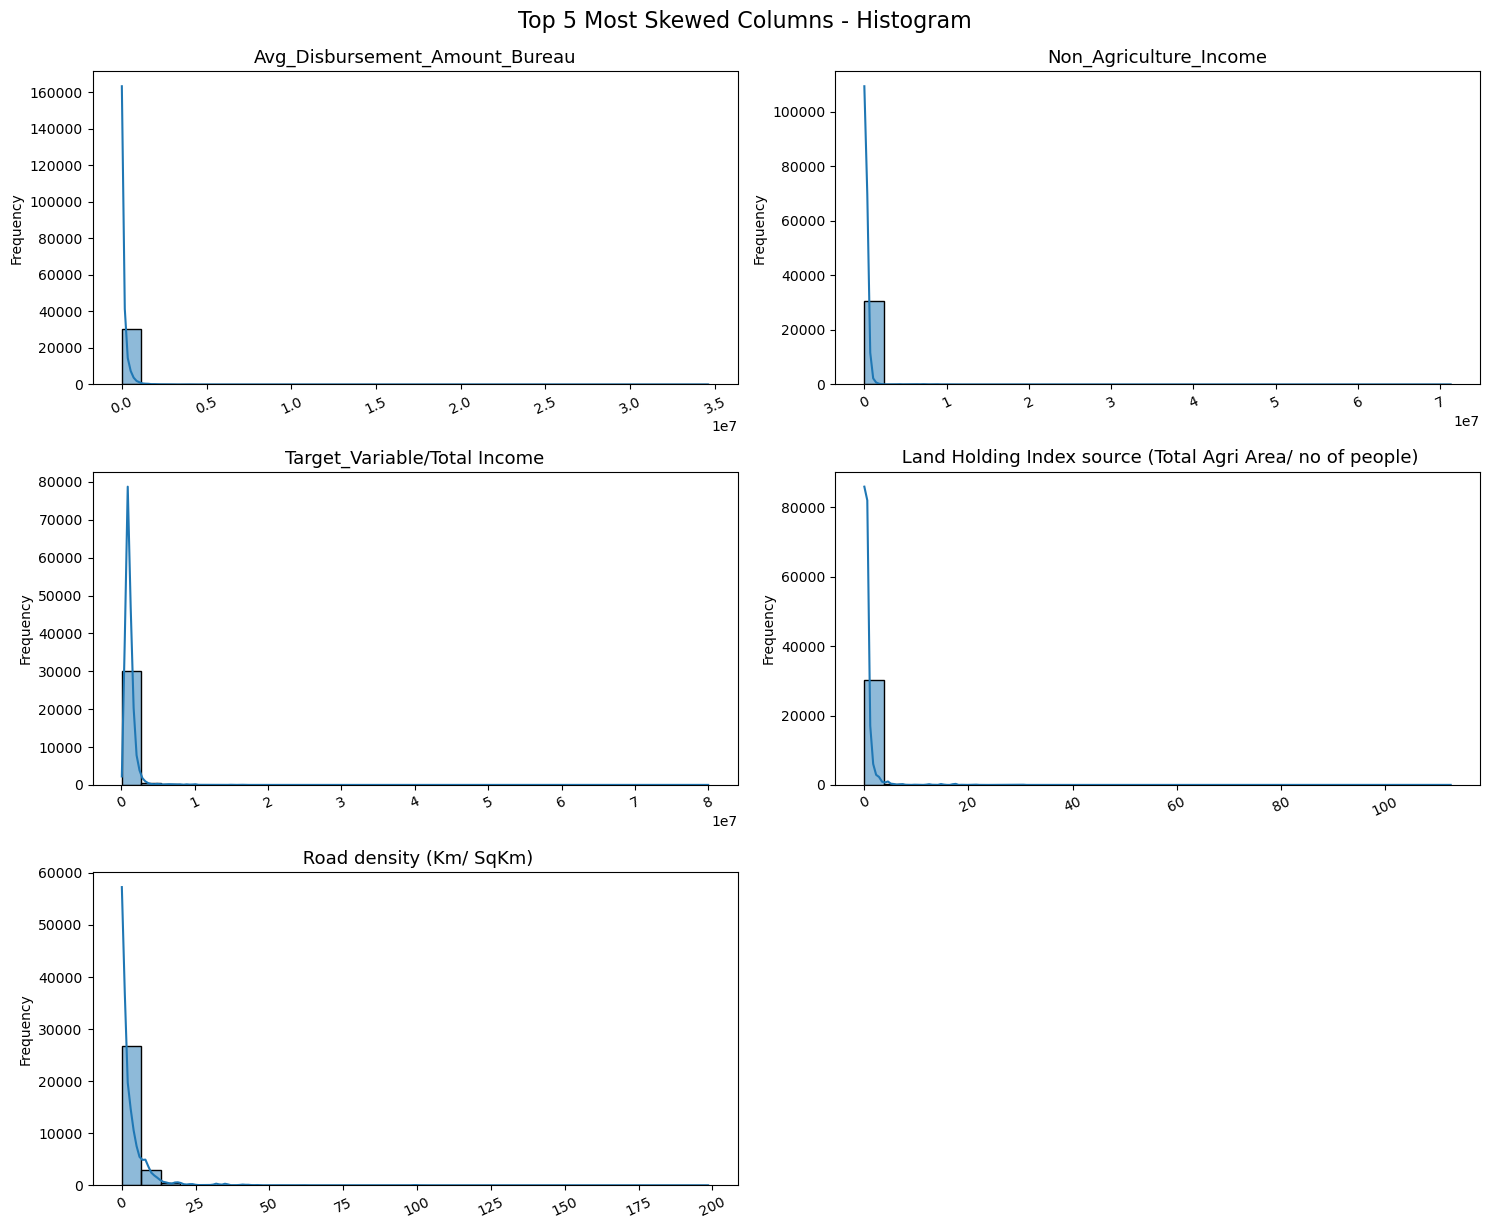

In [96]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(top_5_skewed_cols):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df_Registered_House[col], bins=30, kde=True)
    plt.title(col, fontsize=13)
    plt.xlabel("")  # No x-axis label
    plt.ylabel("Frequency")
    plt.xticks(rotation=25)

plt.tight_layout()
plt.suptitle("Top 5 Most Skewed Columns - Histogram", fontsize=16, y=1.02)
plt.show()

In [97]:
for col in top_5_skewed_cols:
    df_Registered_House[col] = np.log1p(df_Registered_House[col])

C:\Users\HP\AppData\Local\Temp\ipykernel_18700\1901534447.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_Registered_House[col] = np.log1p(df_Registered_House[col])


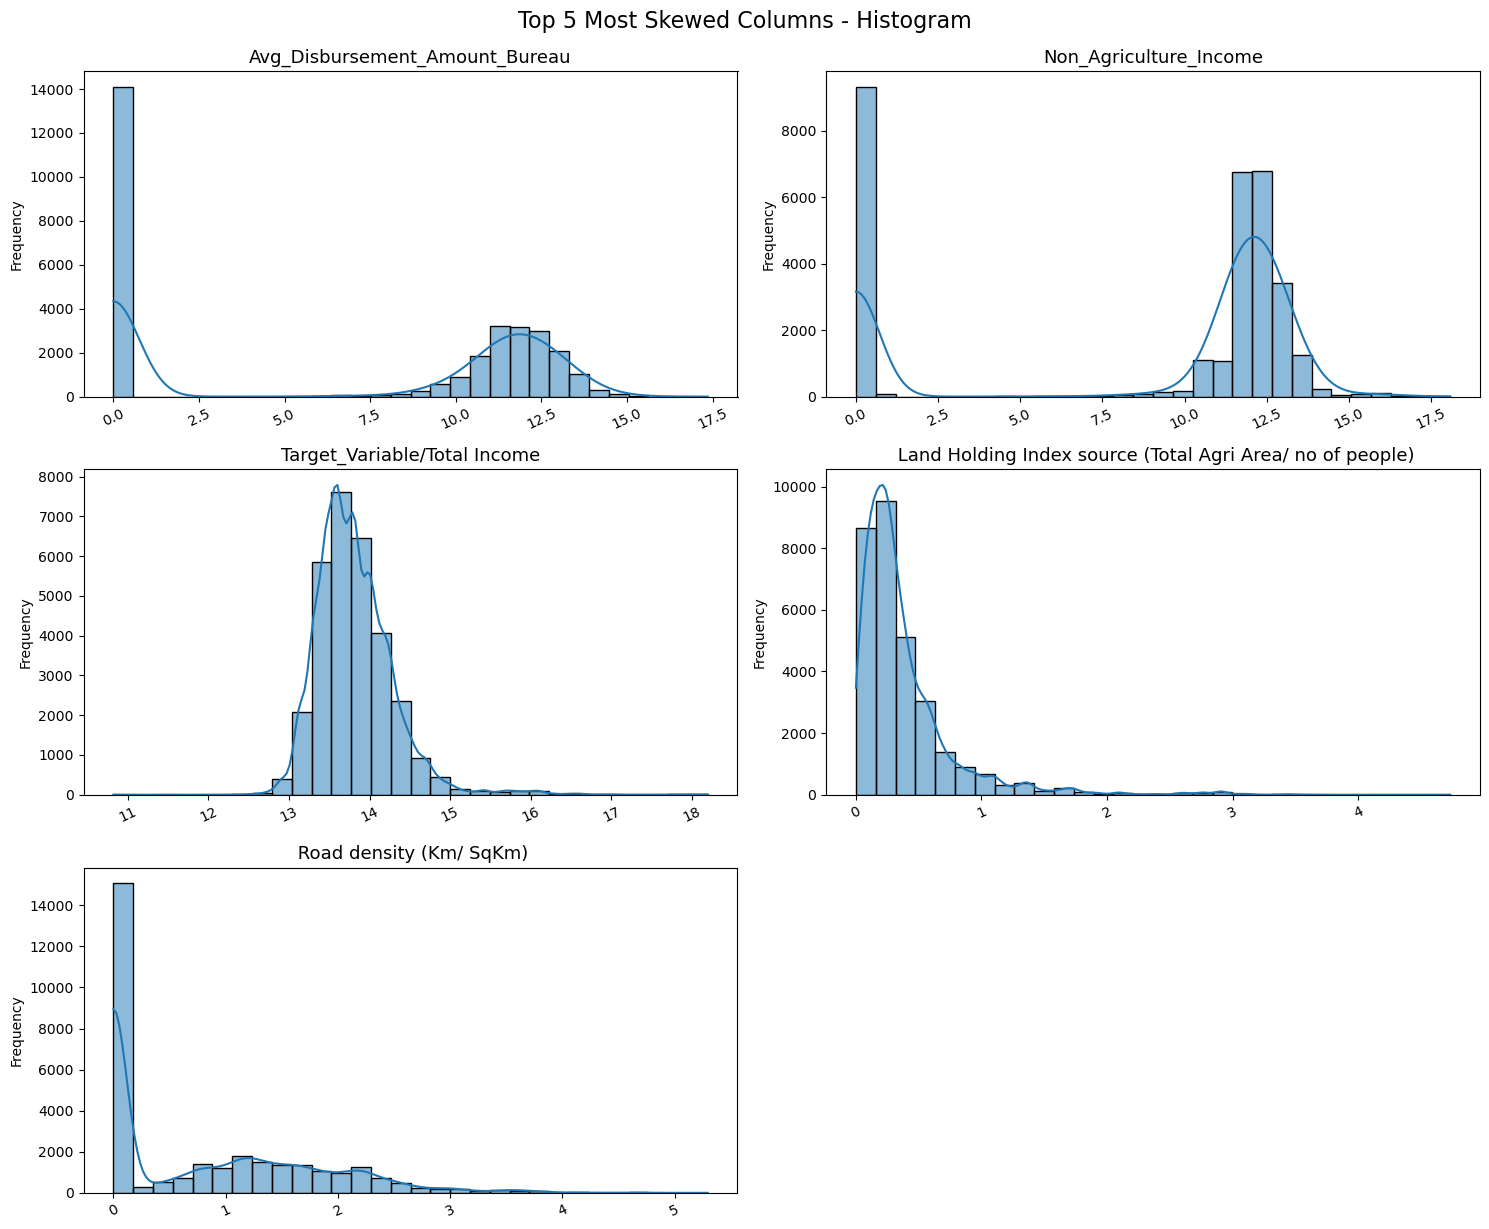

In [98]:
plt.figure(figsize=(15, 12))
for i, col in enumerate(top_5_skewed_cols):
    plt.subplot(3, 2, i + 1)
    sns.histplot(df_Registered_House[col], bins=30, kde=True)
    plt.title(col, fontsize=13)
    plt.xlabel("")  # No x-axis label
    plt.ylabel("Frequency")
    plt.xticks(rotation=25)

plt.tight_layout()
plt.suptitle("Top 5 Most Skewed Columns - Histogram", fontsize=16, y=1.02)
plt.show()

Now we are trying to now find out which features contribute the most in predicting the income (SHAP score)

Firstly using CatboostRegressor we are internally converting the categorical columns for comparision using shap 

In [101]:
cat_cols = df_Registered_House.select_dtypes(include=['object', 'category']).columns.tolist()
num_cols = df_Registered_House.select_dtypes(include=[np.number]).columns.drop('Target_Variable/Total Income').tolist()



In [102]:
converting_categorical_columns= CatBoostRegressor( iterations=300,learning_rate=0.05,depth=6,cat_features=cat_cols, verbose=0, random_seed=42)
converting_categorical_columns.fit(df_Registered_House.drop(columns=["Target_Variable/Total Income"]),df_Registered_House['Target_Variable/Total Income'])

In [106]:
# 1. Average income per village
df_Registered_House['village_income_avg'] = df_Registered_House.groupby('VILLAGE')['Target_Variable/Total Income'].transform('mean')

# 2. Income vs village average (how much better or worse this farmer is)
df_Registered_House['income_vs_village_avg'] = df_Registered_House['Target_Variable/Total Income'] / df_Registered_House['village_income_avg']



In [116]:
# Step 1: Split the data
train_df, test_df = train_test_split(df_Registered_House, test_size=0.2, random_state=42)

# Step 2: Recompute village average income using only train
village_avg_income_dict = train_df.groupby('VILLAGE')['Target_Variable/Total Income'].mean().to_dict()

# Step 3: Add to both train and test sets
train_df['village_income_avg'] = train_df['VILLAGE'].map(village_avg_income_dict)
test_df['village_income_avg'] = test_df['VILLAGE'].map(village_avg_income_dict)

# Step 4: Compute income vs village avg
train_df['income_vs_village_avg'] = train_df['Target_Variable/Total Income'] - train_df['village_income_avg']
test_df['income_vs_village_avg'] = test_df['Target_Variable/Total Income'] - test_df['village_income_avg']


In [122]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import shap
import xgboost as xgb

# ========== Step 1: Setup ==========
df = df_Registered_House.copy()
target_col = "Target_Variable/Total Income"

# Step 2: Split data early to avoid leakage
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Step 3: Create leakage-free group feature (village_income_avg)
village_avg_income = train_df.groupby("VILLAGE")[target_col].mean().to_dict()
train_df["village_income_avg"] = train_df["VILLAGE"].map(village_avg_income)
test_df["village_income_avg"] = test_df["VILLAGE"].map(village_avg_income)

# Step 4: Create income_vs_village_avg
train_df["income_vs_village_avg"] = train_df[target_col] - train_df["village_income_avg"]
test_df["income_vs_village_avg"] = test_df[target_col] - test_df["village_income_avg"]

# Step 5: Drop potential leakage columns (re-add others if needed)
leakage_cols = ['Location', 'Address type', 'Ownership']  # you can expand this if needed
train_df.drop(columns=leakage_cols, errors='ignore', inplace=True)
test_df.drop(columns=leakage_cols, errors='ignore', inplace=True)

# ========== Step 6: Feature Selection Preparation ==========

# Separate features and target
X_train = train_df.drop(columns=[target_col])
y_train = train_df[target_col]
X_test = test_df.drop(columns=[target_col])
y_test = test_df[target_col]

# Identify numeric and categorical columns
cat_cols = X_train.select_dtypes(include='object').columns.tolist()
num_cols = X_train.select_dtypes(include=np.number).columns.tolist()

# Fill missing and encode
preprocessor = ColumnTransformer([
    ("num", SimpleImputer(strategy="mean"), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
])

# ========== Step 7: SHAP Feature Selection ==========

# Fit model for SHAP
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

xgb_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
xgb_model.fit(X_train_transformed, y_train)

# SHAP values
explainer = shap.Explainer(xgb_model)
shap_values = explainer(X_train_transformed)

# Get top 50 feature indices
shap_mean = np.abs(shap_values.values).mean(axis=0)
top_50_indices = np.argsort(shap_mean)[-50:]

# Reduce X_train and X_test to top 50 features
X_train_selected = X_train_transformed[:, top_50_indices]
X_test_selected = X_test_transformed[:, top_50_indices]

# ========== Step 8: Final Model Training ==========

final_model = xgb.XGBRegressor(random_state=42, n_jobs=-1)
final_model.fit(X_train_selected, y_train)

# ========== Step 9: Evaluation ==========

y_pred = final_model.predict(X_test_selected)
r2 = r2_score(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred) * 100

print(f"R² Score: {r2:.4f}")
print(f"MAPE (%): {mape:.2f}")


R² Score: 0.9211
MAPE (%): 0.27


In [124]:
df_test['abs_error'] = abs(y_test - y_pred)
df_test['pct_error'] = df_test['abs_error'] / y_test
df_test[['Total_Income', 'abs_error', 'pct_error']].sort_values(by='pct_error', ascending=False).head(10)


NameError: name 'df_test' is not defined